In [77]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task1-spills.ipynb")

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 2 GitHub repository:

**UPDATE THIS LINK**
https://github.com/kaimorquecho/eds220-hwk3.git


- Review the [complete rubric for this task](https://docs.google.com/document/d/1x0BoU6IH4cnOR1-n7i9CYQ9wUC37yDpYlQ4j6rCfcsU/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

# COMPLETE WORKFLOW

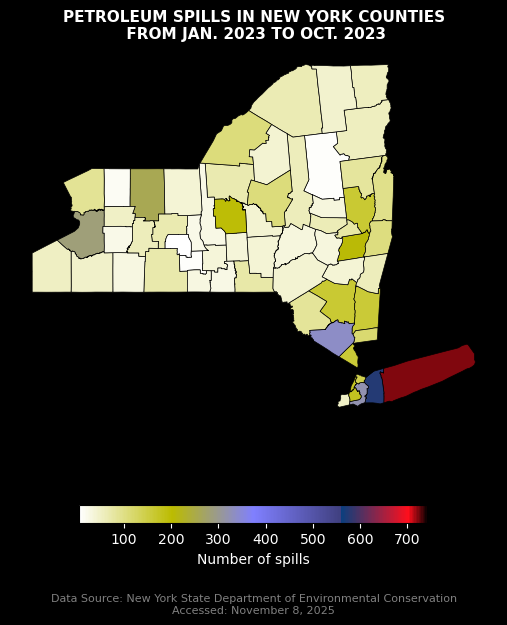

In [78]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import data3
# Set the path for project's library 
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Construct file path for spills dataset using 'os' package
fp = os.path.join('data','Spill_Incidents_20251107.csv')
spills = pd.read_csv(fp)

# Construct file path for counties dataset using 'os' package
fp = os.path.join('data','tl_2023_us_county','tl_2023_us_county.shp')
counties = gpd.read_file(fp)


# Simplify column names in spills DataFrame
spills.columns = spills.columns.str.lower().str.replace(' ','_') 

# Update 'spill_date' to a datetime object 
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Update index to column 'spill_date' to subset using the index
spills = spills.set_index('spill_date')

# NAs in the spill_date index prevent the index from being sorted, drop NAs and sort
spills = spills[spills.index.notna()].sort_index()

# Use label indexing to subset to petroleum spills from 01-1-2023 - 10-31-2023
petr_23 = spills.loc[(spills.index >= '2023-01-01') & 
                     (spills.index <= '2023-10-31') & (spills['material_family'] == 'Petroleum')]


# Create new dataframe named spills_per_county with the number of petroleum spills per county from January to October 2023 
spills_per_county = (petr_23.reset_index()
                            .groupby('county',as_index = False)['spill_date']
                            .count().rename(columns={'spill_date':'n_spills'}))

# Update column names in counties DataFrame to lowercase
counties.columns = counties.columns.str.lower()

# Select NY counties using 'statefp' column, NY is 'statefp'=36
ny_counties = counties[counties['statefp'] == '36']

# Replace 'St Lawrence' county value with 'St. Lawrence' in spills_per_county DataFrame
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# DataFrames have different column names, rename ny_counties column 'name' to 'county'
ny_counties = ny_counties.rename(columns = {'name':'county'})

# Inner join ny_counties and spills_per_county DataFrames on 'county' column
ny_counties = pd.merge(ny_counties, spills_per_county, on = 'county', how = 'inner')

# Add one spill to Niagara county to make up for Tuscarora Indian Reservation not being in the DataFrame anymore
ny_counties.loc[ny_counties.county=='Niagara','n_spills'] += 1


# Create cloropleth map of petroleum spills
fig, ax = plt.subplots(figsize = (9,7))

fig.patch.set_facecolor("black")  # Change background color


# Leave axis on 
ax.axis('off')

# Create cloropleth
ny_counties.plot(ax = ax,
                 column = 'n_spills',
                 cmap = 'gist_stern_r',
                 legend=True,
                 edgecolor = 'black',
                 linewidth=0.5,
                 legend_kwds={
                    "shrink": 0.5,
                    "label": "Number of spills",
                    "orientation": "horizontal",
                    "pad":0.15
                 }
                )

# Add title and annotation that includes data citation and date of access
ax.set_title('PETROLEUM SPILLS IN NEW YORK COUNTIES\n FROM JAN. 2023 TO OCT. 2023', 
             weight='bold', 
             fontsize=11,
             color='white')

ax.annotate('Data Source: New York State Department of Environmental Conservation\nAccessed: November 8, 2025',
 xy=(0.5, -0.5),
    xycoords='axes fraction',
    ha='center', 
    fontsize=8,
    color='gray'
)

# Add a grid and make aesthethic adjustments
ax.grid(True, which='major',
        color='lightgray',
        linestyle='--',
        linewidth=0.5)

# Update size and color of plot's ticks 
ax.tick_params(
    labelsize=7,     
    labelcolor='white' 
)

# Access and update colorbar's text color
cbar = ax.get_figure().axes[-1]

# Change color of the tick labels and label
cbar.tick_params(colors='white')  
cbar.xaxis.label.set_color('white')  

plt.show()

## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your commit history if you try to push them.

## 2. Datasets description
- Read the metadata for both datsets and write a brief description about each one. Indicate the date sources and date of access.

### Oil Spills Data
This dataset records reported incidents of petroleum and other hazardous material spills across New York State reported by the spiller. It includes information like unique spill number, date/time, location (including county), material type and family etc. It is worth noting that this data is not fact-checked or field-checked, thus accuracy cannot be guaranteed, per the NYSDEC. The data also comes with extensive documentation for context and interpretation.

**Data Source:**
[New York State Department of Environmental Conservation](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk/about_data) 

**Date of access:**
11/07/2025

### TIGER shapefile data
This data consists of shapefiles with geometries of US counties and is provided by the US Census Bureau. The website allows users to select different shapefile options (county-level, state-level). County-level data was accessed for the purpose of this analysis.

**Data Source:**
[United States Census Bureau TIGER/Line Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)

**Date of access:**
11/07/2025

## 3. Import libraries

In [79]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [80]:
# Set the path for project's library 
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Construct file path for spills dataset using 'os' package
fp = os.path.join('data','Spill_Incidents_20251107.csv')
spills = pd.read_csv(fp)

# Construct file path for counties dataset using 'os' package
fp = os.path.join('data','tl_2023_us_county','tl_2023_us_county.shp')
counties = gpd.read_file(fp)


<!-- BEGIN QUESTION -->

## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head

b. Check the data types of the columns

c. Check the unique values in the `material_family` column

d. Check the unique values in the `county` column

e. Insert a markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells for preliminary data exploration.

In [81]:
#a. Check the dataframe's head
spills.head(5)

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6,Gallons,6


In [82]:
#b. Check the data types of the columns
spills.dtypes

Spill Number              int64
Program Facility Name    object
Street 1                 object
Street 2                 object
Locality                 object
County                   object
ZIP Code                 object
SWIS Code                 int64
DEC Region                int64
Spill Date               object
Received Date            object
Contributing Factor      object
Waterbody                object
Source                   object
Close Date               object
Material Name            object
Material Family          object
Quantity                 object
Units                    object
Recovered                object
dtype: object

In [83]:
# Check Dimensions
spills.shape

(563659, 20)

In [84]:
#c. Check the unique values in the `material_family` column

# Simplify column names in spills DataFrame
spills.columns = spills.columns.str.lower().str.replace(' ','_') 

# View new column names
print('Simplified column names:\n', spills.columns.tolist())

# View material_family unique values
print('\nmaterial_family unique values:\n',spills['material_family'].unique()) # Output: array of unique values in 'material_family' column

Simplified column names:
 ['spill_number', 'program_facility_name', 'street_1', 'street_2', 'locality', 'county', 'zip_code', 'swis_code', 'dec_region', 'spill_date', 'received_date', 'contributing_factor', 'waterbody', 'source', 'close_date', 'material_name', 'material_family', 'quantity', 'units', 'recovered']

material_family unique values:
 ['Other' 'Petroleum' 'Hazardous Material' 'Oxygenates']


In [85]:
#d. Check the unique values in the `county` column
print(spills['county'].unique())

print(len(spills['county'].unique()))

['Westchester' 'Queens' 'Bronx' 'Sullivan' 'Cortland' 'New York' 'Ulster'
 'Kings' 'Orange' 'Dutchess' 'Onondaga' 'Saratoga' 'Cayuga' 'Oswego'
 'Warren' 'Niagara' 'Rockland' 'Nassau' 'Jefferson' 'Schenectady' 'Albany'
 'Monroe' 'Schuyler' 'St Lawrence' 'Richmond' 'Clinton' 'Lewis' 'Essex'
 'Chenango' 'Erie' 'Livingston' 'Oneida' 'Wayne' 'Suffolk' 'Orleans'
 'Ontario' 'Genesee' 'Otsego' 'Tompkins' 'Madison' 'Chemung' 'Seneca'
 'Broome' 'Hamilton' 'Washington' 'Steuben' 'Rensselaer' 'Franklin'
 'Columbia' 'Fulton' 'Herkimer' 'Schoharie' 'Montgomery' 'Putnam'
 'Delaware' 'New Jersey - Region 2' 'Tioga' 'Chautauqua' 'Cattaraugus'
 'Wyoming' 'Yates' 'Greene' 'Pennsylvania - Region 9' 'Allegany'
 'New Jersey - Region 3 (N)' 'Cattaraugus Indian Reservation'
 'New Jersey - Region 3 (T)' 'Canada - Region 6' 'Canada - Region 9'
 'Pennsylvania - Region 8' 'Vermont - Region 5 (R)' 'Vermont - Region 4'
 'Connecticut - Region 3 (N)' 'Pennsylvania - Region 3'
 'Tuscarora Indian Reservation' 'Connecti

e. During my data exploration of the `spills` DataFrame I learned about its data types, column names, shape, and unique values. Columns `SWIS Code`, `Spill Number`, and `DEC Region` are of data type `int64` and all other columns are `object`, most likely strings. The dataset's `county` column covers 87 unique locations. The exploration of the `material_family` provides information on the 4 materials/labels that spills can fall under. Lastly, the shape of the DataFrame consists of 563508 observations and 19 columns.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.B. Cleaning
a. Simplify column names as needed.

I simplified column names in cell C since instructions asked to check column 'material_family' and the column was not yet named that

```
spills.columns = spills.columns.str.lower().str.replace(' ','_')
```

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Update column data types as needed *for this analysis*.

In [86]:
# Update 'spill_date' to a datetime object 
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

In [87]:
# Check that 'spill_date' is now a datetime object
spills.dtypes

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date                    object
contributing_factor              object
waterbody                        object
source                           object
close_date                       object
material_name                    object
material_family                  object
quantity                         object
units                            object
recovered                        object
dtype: object

In [88]:
# Update index to column 'spill_date' to subset using the index
spills = spills.set_index('spill_date')

In [89]:
# NAs in the spill_date index prevent the index from being sorted, drop NAs and sort
spills = spills[spills.index.notna()].sort_index()

In [90]:
# Double-check that it's truly monotonic now
assert(spills.index.is_monotonic_increasing)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [91]:
# Use label indexing to subset to petroleum spills from 01-1-2023 - 10-31-2023
petr_23 = spills.loc[(spills.index >= '2023-01-01') & 
                     (spills.index <= '2023-10-31') & (spills['material_family'] == 'Petroleum')]

petr_23

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
spill_date,,,,,,,,,,,,,,,,,,,
2023-01-01,2208105,CUMBERLAND FARMS #3276,107 MAIN ST,PBS # 5-601128,GLENS FALLS,Warren,NaN,5705,5,01/01/2023,Unknown,NaN,Gasoline Station or other PBS Facility,04/03/2023,gasoline,Petroleum,0,Gallons,0
2023-01-01,2208109,CON ED TRANSMISSION FEEDER PIPE Y50,HANCOCK ST & EAST 5TH ST,NaN,MOUNT VERNON,Westchester,NaN,6018,3,01/01/2023,Equipment Failure,NaN,Commercial/Industrial,05/03/2023,dielectric fluid,Petroleum,"1,976",Gallons,0
2023-01-01,2208111,ART PETROLEUM,55 WINDSOR AVE,NaN,MINEOLA,Nassau,NaN,3020,1,01/01/2023,Equipment Failure,NaN,Commercial Vehicle,01/12/2023,diesel,Petroleum,0,NaN,0
2023-01-01,2208120,VACANT RESIDENTIAL,200 MAIN STREET,NaN,TUPPER LAKE,Franklin,12986,1720,5,01/02/2023,Equipment Failure,NaN,Private Dwelling,03/11/2025,#2 fuel oil,Petroleum,0,NaN,0
2023-01-01,2208106,POLE 22668,135 MYERS CORNERS RD,NaN,WAPPINGER FALLS,Dutchess,NaN,1456,3,01/01/2023,Traffic Accident,NaN,Transformer,01/04/2023,transformer oil,Petroleum,5,Gallons,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,2307025,COMMERCIAL - NORBIT,223 WEST GENESEE ST,NaN,AUBURN,Cayuga,NaN,601,7,11/21/2023,Equipment Failure,NaN,Commercial/Industrial,12/13/2023,hydraulic oil,Petroleum,0,NaN,0
2023-10-31,2306491,CAR FIRE,MONTAUK HWY & HECKSCHER STATE PARKWAY,NaN,EAST ISLIP,Suffolk,NaN,5228,1,10/31/2023,Other,NaN,Passenger Vehicle,11/01/2023,gasoline,Petroleum,4,Gallons,0
2023-10-31,2307988,BAKER RESIDENCE,555 JERSEY SWAMP ROAD,NaN,WEST CHAZY,Clinton,12992,1024,5,01/03/2024,Equipment Failure,NaN,Private Dwelling,01/30/2024,hydraulic oil,Petroleum,10,Gallons,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print a message verifying that `petr_23` only has data for 2023 and from January through October.
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`.

In [92]:
print(
    "petr_23 contains data for the following dates:\n "
    + ", ".join(
        petr_23.index
        .normalize()
        .unique()
        .strftime("%Y-%m-%d")
    )
)


petr_23 contains data for the following dates:
 2023-01-01, 2023-01-02, 2023-01-03, 2023-01-04, 2023-01-05, 2023-01-06, 2023-01-07, 2023-01-08, 2023-01-09, 2023-01-10, 2023-01-11, 2023-01-12, 2023-01-13, 2023-01-14, 2023-01-15, 2023-01-16, 2023-01-17, 2023-01-18, 2023-01-19, 2023-01-20, 2023-01-21, 2023-01-22, 2023-01-23, 2023-01-24, 2023-01-25, 2023-01-26, 2023-01-27, 2023-01-28, 2023-01-29, 2023-01-30, 2023-01-31, 2023-02-01, 2023-02-02, 2023-02-03, 2023-02-04, 2023-02-05, 2023-02-06, 2023-02-07, 2023-02-08, 2023-02-09, 2023-02-10, 2023-02-11, 2023-02-12, 2023-02-13, 2023-02-14, 2023-02-15, 2023-02-16, 2023-02-17, 2023-02-18, 2023-02-19, 2023-02-20, 2023-02-21, 2023-02-22, 2023-02-23, 2023-02-24, 2023-02-25, 2023-02-26, 2023-02-27, 2023-02-28, 2023-03-01, 2023-03-02, 2023-03-03, 2023-03-04, 2023-03-05, 2023-03-06, 2023-03-07, 2023-03-08, 2023-03-09, 2023-03-10, 2023-03-11, 2023-03-12, 2023-03-13, 2023-03-14, 2023-03-15, 2023-03-16, 2023-03-17, 2023-03-18, 2023-03-19, 2023-03-20, 2023

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [93]:
# Assert test 1 using .all()
assert(petr_23['material_family'] == 'Petroleum').all()

# Assert test 2 using set()
assert set(petr_23['material_family']) == {'Petroleum'}

# Assert test 3 using nunique()
assert((petr_23['material_family'] == 'Petroleum').nunique() == 1)

# All tests passed

<!-- END QUESTION -->

### 5.D. Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Two columns only.
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.

In [94]:
# Create new dataframe named spills_per_county with the number of petroleum spills per county from January to October 2023 
spills_per_county = (petr_23.reset_index()
                            .groupby('county',as_index = False)['spill_date']
                            .count().rename(columns={'spill_date':'n_spills'}))

In [95]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head

b. Check the data types of the columns

c. Check the geo-dataframe's CRS

d. Plot the geo-dataframe

e. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells of preliminary data exploration.

During my data exploration of the `counties` geo-DataFrame I learned about its data types, column names, shape, and CRS. Plotting the DataFrame using `plot()` provides a visual on the extent of the DataFrame before performing any filtering - It is the map of the continental U.S and Alaska. The data type of the columns is primarily `object`, with the exception of the geometries column and two `int64` columns. Finally, I learned about the geo-DataFrame's Coordinate Reference System, which is `NAD83`. 

In [96]:
# a 
counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."


In [97]:
# b
counties.dtypes

STATEFP       object
COUNTYFP      object
COUNTYNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CSAFP         object
CBSAFP        object
METDIVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [98]:
# c
counties.crs

<Geographic 2D CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_Am ...>
Name: NAD83
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

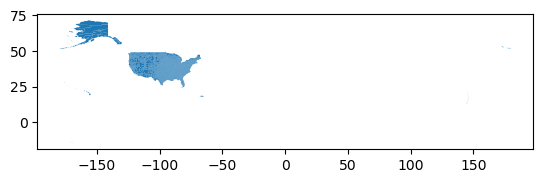

In [99]:
# d
counties.plot()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [100]:
# Update column names in counties DataFrame to lowercase
counties.columns = counties.columns.str.lower()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them (you may need to look at the metadata).

<Axes: >

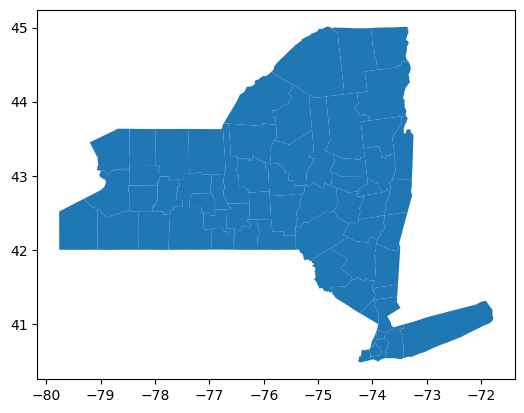

In [101]:
# Select NY counties using 'statefp' column, NY is 'statefp'=36
ny_counties = counties[counties['statefp'] == '36']

ny_counties.plot()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.


In [102]:
print(set(ny_counties['name'])) # Set() removes any duplicates in the 'name' column 

{'Bronx', 'Schuyler', 'Allegany', 'Nassau', 'Tioga', 'Schoharie', 'Wyoming', 'Suffolk', 'Rensselaer', 'Columbia', 'Orleans', 'Wayne', 'Genesee', 'Westchester', 'Putnam', 'Orange', 'Fulton', 'Warren', 'Tompkins', 'Lewis', 'Kings', 'Saratoga', 'Onondaga', 'Seneca', 'Otsego', 'Cattaraugus', 'Ontario', 'Dutchess', 'Richmond', 'Madison', 'Greene', 'Niagara', 'Montgomery', 'Chautauqua', 'St. Lawrence', 'Monroe', 'Washington', 'Ulster', 'Oneida', 'Chemung', 'Queens', 'Herkimer', 'Franklin', 'Schenectady', 'Essex', 'Steuben', 'Oswego', 'Clinton', 'Cortland', 'Cayuga', 'Delaware', 'Sullivan', 'Jefferson', 'Yates', 'Livingston', 'Erie', 'Chenango', 'Rockland', 'New York', 'Hamilton', 'Albany', 'Broome'}


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.

In [103]:
print(set(spills_per_county['county'])) # Set() removes any duplicates in the 'county' column 

{'Bronx', 'Schuyler', 'Allegany', 'Nassau', 'Schoharie', 'Tioga', 'Wyoming', 'St Lawrence', 'Suffolk', 'Rensselaer', 'Columbia', 'Orleans', 'Wayne', 'Genesee', 'Orange', 'Putnam', 'Westchester', 'Fulton', 'Tompkins', 'Warren', 'Lewis', 'Kings', 'Onondaga', 'Saratoga', 'Seneca', 'Otsego', 'Cattaraugus', 'Ontario', 'Dutchess', 'Richmond', 'Madison', 'Chautauqua', 'Greene', 'Montgomery', 'Niagara', 'Monroe', 'Washington', 'Ulster', 'New Jersey - Region 2', 'Tuscarora Indian Reservation', 'Oneida', 'Chemung', 'Queens', 'Herkimer', 'Franklin', 'Schenectady', 'Essex', 'Oswego', 'Steuben', 'Clinton', 'Cortland', 'Cayuga', 'Delaware', 'Sullivan', 'Jefferson', 'Yates', 'Livingston', 'Erie', 'Chenango', 'Rockland', 'New York', 'Hamilton', 'Albany', 'Broome'}


<!-- END QUESTION -->



c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 


In [104]:
# Find counties found in spills_per_county DataFrame and not in ny_counties
diff_names_spills = np.setdiff1d(spills_per_county['county'],ny_counties['name']).tolist() # Output: A list of counties not in ny_counties DataFrame

diff_names_spills

['New Jersey - Region 2', 'St Lawrence', 'Tuscarora Indian Reservation']

In [105]:
grader.check("7Ac")

7Ac results: All test cases passed!

d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [106]:
# Find counties found in ny_counties DataFrame and not in spills_per_county
diff_names_ny = np.setdiff1d(ny_counties['name'],spills_per_county['county']).tolist()

diff_names_ny # Output: List of the one county not found in the spills_per_county DataFrame

['St. Lawrence']

In [107]:
grader.check("7Ad")

7Ad results: All test cases passed!

e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [108]:
# e. 
spills_per_county[spills_per_county['county'] == 'Tuscarora Indian Reservation'] # Output: DataFrame with one observation. There is 1 spill in Tuscarora Indian Reservation

,county,n_spills
56,Tuscarora Indian Reservation,1


### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and Verify the update was successful.


In [109]:
# Replace 'St Lawrence' county value with 'St. Lawrence'
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# Confirm that value was updated to 'St.Lawrence'
spills_per_county[spills_per_county['county'] == 'St. Lawrence'] 

,county,n_spills
50,St. Lawrence,65


### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 


In [110]:
# Prepare DataFrames for merging: Rename ny_counties' column 'name' to 'county' to match spills_per_county column names
ny_counties = ny_counties.rename(columns = {'name':'county'})

b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [111]:
# Inner join ny_counties and spills_per_county DataFrames on 'county' column
ny_counties = pd.merge(ny_counties, spills_per_county, on = 'county', how = 'inner')

In [112]:
# Verify Tuscarora Indian Reservation not in ny_counties
(ny_counties['county'] == 'Tuscarora Indian Reservation').sum()

0


From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [113]:
# Add one spill to Niagara county to make up for Tuscarora Indian Reservation not being in the DataFrame anymore
ny_counties.loc[ny_counties.county=='Niagara','n_spills'] += 1

In [114]:
# Verify that n_spill value went from 88 to 89 observations for Niagara county
ny_counties[ny_counties.county == 'Niagara']['n_spills']

45    89
Name: n_spills, dtype: int64

## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation) and date of access



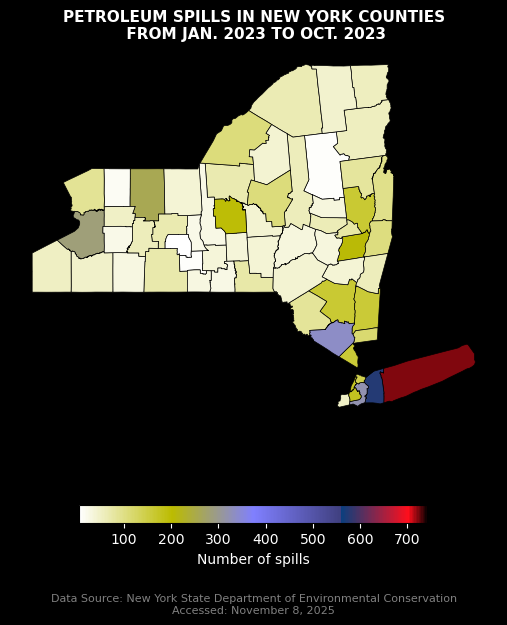

In [115]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import data
# Set the path for project's library 
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Construct file path for spills dataset using 'os' package
fp = os.path.join('data','Spill_Incidents_20251107.csv')
spills = pd.read_csv(fp)

# Construct file path for counties dataset using 'os' package
fp = os.path.join('data','tl_2023_us_county','tl_2023_us_county.shp')
counties = gpd.read_file(fp)

# Simplify column names in spills DataFrame
spills.columns = spills.columns.str.lower().str.replace(' ','_') 

# Update 'spill_date' to a datetime object 
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Update index to column 'spill_date' to subset using the index
spills = spills.set_index('spill_date')

# NAs in the spill_date index prevent the index from being sorted, drop NAs and sort
spills = spills[spills.index.notna()].sort_index()

# Use label indexing to subset to petroleum spills from 01-1-2023 - 10-31-2023
petr_23 = spills.loc[(spills.index >= '2023-01-01') & 
                     (spills.index <= '2023-10-31') & (spills['material_family'] == 'Petroleum')]


# Create new dataframe named spills_per_county with the number of petroleum spills per county from January to October 2023 
spills_per_county = (petr_23.reset_index()
                            .groupby('county',as_index = False)['spill_date']
                            .count().rename(columns={'spill_date':'n_spills'}))

# Update column names in counties DataFrame to lowercase
counties.columns = counties.columns.str.lower()

# Select NY counties using 'statefp' column, NY is 'statefp'=36
ny_counties = counties[counties['statefp'] == '36']

# Replace 'St Lawrence' county value with 'St. Lawrence' in spills_per_county DataFrame
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# DataFrames have different column names, rename ny_counties column 'name' to 'county'
ny_counties = ny_counties.rename(columns = {'name':'county'})

# Inner join ny_counties and spills_per_county DataFrames on 'county' column
ny_counties = pd.merge(ny_counties, spills_per_county, on = 'county', how = 'inner')

# Add one spill to Niagara county to make up for Tuscarora Indian Reservation not being in the DataFrame anymore
ny_counties.loc[ny_counties.county=='Niagara','n_spills'] += 1


# Create cloropleth map of petroleum spills
fig, ax = plt.subplots(figsize = (9,7))

fig.patch.set_facecolor("black")  # Change background color


# Leave axis on 
ax.axis('off')

# Create cloropleth
ny_counties.plot(ax = ax,
                 column = 'n_spills',
                 cmap = 'gist_stern_r',
                 legend=True,
                 edgecolor = 'black',
                 linewidth=0.5,
                 legend_kwds={
                    "shrink": 0.5,
                    "label": "Number of spills",
                    "orientation": "horizontal",
                    "pad":0.15
                 }
                )

# Add title and annotation that includes data citation and date of access
ax.set_title('PETROLEUM SPILLS IN NEW YORK COUNTIES\n FROM JAN. 2023 TO OCT. 2023', 
             weight='bold', 
             fontsize=11,
             color='white')

ax.annotate('Data Source: New York State Department of Environmental Conservation\nAccessed: November 8, 2025',
 xy=(0.5, -0.5),
    xycoords='axes fraction',
    ha='center', 
    fontsize=8,
    color='gray'
)

# Add a grid and make aesthethic adjustments
ax.grid(True, which='major',
        color='lightgray',
        linestyle='--',
        linewidth=0.5)

# Update size and color of plot's ticks 
ax.tick_params(
    labelsize=7,     
    labelcolor='white' 
)

# Access and update colorbar's text color
cbar = ax.get_figure().axes[-1]

# Change color of the tick labels and label
cbar.tick_params(colors='white')  
cbar.xaxis.label.set_color('white')  

plt.show()

b. Write a description of how the map was created, including key takeaways. If you need to do additional data analysis to include relevant information from the data, you may include additional cells here.

To create the cloropleth map of petroleum spills by county in New York, I first prepared the data by subsetting the spill incidents to include only petroleum spills from January to October 2023. I then aggregated the number of spills per county using the groupby function. Next, I prepared the geographic data by loading New York State county boundaries from TIGER shapefiles. I checked both datasets for duplicates and ensured that county names matched between the spill and spatial data, using set differences to identify any discrepancies. I also verified that the coordinate reference systems (CRS) were aligned to allow accurate plotting. Finally, I merged the aggregated spill data with the county shapefiles and used matplotlib and geopandas to create a choropleth map, adding a color bar and an annotation noting the data source and access date. The resulting map visualizes the number of petroleum spills per county in New York from January through October 2023 with spill incident data provided by the New York State Department of Environmental Conservation. The color gradient indicates the number of spills, with darker shades representing higher counts. Counties with the most spills are concentrated near waterways, as expected. Particularly around Long Island Sound. The top five counties with the highest number are obtained in the cell below and they are Westchester, Suffolk, Nassau, Erie, and Albany. These are regions where spill frequency is notably elevated. This visualization provides insight into geographic patterns of environmental risk across the state.

In [116]:
spills_per_county.sort_values(by='n_spills', ascending=False).head(5)

,county,n_spills
61,Westchester,744
52,Suffolk,723
29,Nassau,576
36,Orange,336
41,Queens,321


## Complete workflow

**STILL WORKING ON THIS**

Collect all the relevant code into a **new notebook** titled `hwk3-task1-spills-COMPLETE-YOURLASTNAME.ipynb`. This notebook should have two sections:the a single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.



**From last HW:**

Collect all the relevant code into the first blank cell of the notebook titled "COMPLETE WORKFLOW". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.

##### Run the cell below to run all autograder tests. 

In [117]:
grader.check_all()

7Ac results: All test cases passed!

7Ad results: All test cases passed!

q5d results:
    q5d - 1 result:
        ❌ Test case failed
        Trying:
            def test_q3(student_data):
                try:
                    expected_data = pd.read_csv('data/q5d_df.csv').drop(columns='Unnamed: 0')
                    pd.testing.assert_frame_equal(expected_data, student_data)
                except AssertionError:
                    raise AssertionError('Incorrect answer.')
        Expecting nothing
        ok
        Trying:
            test_q3(spills_per_county)
        Expecting nothing
        **********************************************************************
        Line 7, in q5d 0
        Failed example:
            test_q3(spills_per_county)
        Exception raised:
            Traceback (most recent call last):
              File "<doctest q5d 0[0]>", line 4, in test_q3
                pd.testing.assert_frame_equal(expected_data, student_data)
              File "/op